In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18  # Planck 2018 cosmology
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.modeling.models import Schechter1D

In [2]:
# Set given conditions 
local = 0.1
survey_area = 10 * u.deg**2
lim_app_mag = 22
robust = 20.8

Q1) remove any non-robustly detected galaxies from the catalogue

In [3]:
#Read in csv file
data = pd.read_csv("Survey_Scattergood.csv")

#select all rows with a K band magnitude of < 20.8
robust_data = data[data["K-band mag"] <= robust]

# check that highest K band mag is <= 20.8
assert robust_data["K-band mag"].max() <= robust, f"data contains galaxies with K band mag > {robust}" 


Q2) produce a plot showing the number counts of the robustly-detected galaxies in the catalogue

In [4]:
def number_counts(dataframe, col, bins):
    """
    A function that plots the number counts of the robustly detected galaxies

    parameters
    - dataframe, pandas DataFrame, the dataframe to read data from
    - col, pandas Series, the olumn to read data from, column name must be passed as a string
    - bins, the number of bins to plot on the histogram
    
    Returns
    - None
    """  
    plt.hist(dataframe[col], bins=bins, log=True, histtype="step")
    plt.title("galaxy number counts of robustly detected galaxies")
    plt.xlabel("Apparent K band magnitude")
    plt.ylabel(r"${{Log_{10}} N}$")
    plt.xlim(8.5,20.8)
    return None

Q2) produce a plot showing the number counts of the robustly-detected galaxies

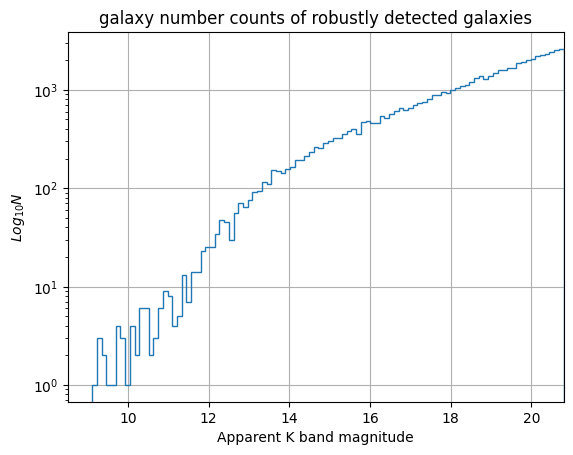

In [5]:
# plot number of counts of robust galaxies
number_counts(robust_data, "K-band mag", 100)
plt.grid()

Q3) select only z < 0.1 galaxies

In [6]:
# select local galaxies, i.e, with Redshift < 0.1
local_galaxies = robust_data[robust_data["Redshift"] <= local]

# check that only local galaxies are seleceted 
assert local_galaxies["Redshift"].max() <= local, f"data contains redshifts > {local}"

# Create numpy arrays from each column
Z = local_galaxies["Redshift"].to_numpy()
K_mag = local_galaxies["K-band mag"].to_numpy()
K_dmag = local_galaxies["K-band dmag"].to_numpy()

#print(local_galaxies.shape)
local_galaxies.head()



,Redshift,K-band mag,K-band dmag
10,0.079,19.969,0.156
12,0.095,19.070,0.071
24,0.083,19.973,0.156
25,0.033,19.939,0.152
33,0.083,17.248,0.014


Q4) calculate the volume of the z < 0.1 Universe covered by the survey, assuming a Planck 2018
cosmology

The cosmological volume, Vc, within a given redshift, z, is equal to:
$$
V_c = \frac{4}{3} \pi d_p^3
$$

Where $d_p$ is the proper distance or the comoving distance 

The volume sample, $V_s$, is then given by:

$$
V_s = \frac{X}{41252.96} [V_c(Z_2) - V_c(Z_1)]
$$

where X is the survery area in square degrees, $V_c(Z_2)$ and $V_c(Z_1)$ are the cosmological volumes at redshifts $Z_2$ and $Z_1$ which are taken as the maximum and minimum redshifts respectively in the catalogue 

In [7]:
def survey_volume(redshift, area):
    """
    A function that calculates the volume of a survey given a redshift and a survey area

    Parameters:
    - redshift, float/array, redshift value(s) of object(s) (e.g. galaxy, star)
    - area, float, area of survey in square degrees

    Returns:
    - Vs, Survery volume in cubic Mpc
    """
    dp = Planck18.comoving_distance(redshift)
    Vc = 4/3 * np.pi * dp**3
    Vs = area.value/41252.96 * (Vc.max() - Vc.min())   
    return Vs

In [8]:
Vs = survey_volume(Z, survey_area)
print(f"The volume of the sample is {Vs:.3f}")

The volume of the sample is 82173.461 Mpc3


Q5) calculate the luminosity distance of each z < 0.1 galaxy in the catalogue, again assuming a Planck 2018 cosmology

In [9]:
#Calculate Luminsity distance of all z < 0.1 galaxies using the plank18 inbuilt function 
Lum_dis = Planck18.luminosity_distance(Z).to(u.pc) # In pcs
Lum_dis_np = np.array(Lum_dis) # create numpy array of luminosity distance 

#Lum_dis = np.array(Planck18.luminosity_distance(Z).to(u.pc)) # In pcs
print(Lum_dis_np)

[3.70629134e+08 4.50531339e+08 3.90456740e+08 ... 3.65687746e+08
 2.06154697e+08 4.75822268e+08]


Q6) calculate the absolute magnitude of each z < 0.1 galaxy, including errors

Absolute magnitude, M is given by:

$$
M = m − 5log10(d_L) + 5.
$$

Where m is apparent magnitude and $d_L$ is luminosity distance in parsecs 

In [10]:
# Calculate absolute magnitude, M, of all z < 0.1 galaxies
absolute_mag = K_mag - 5*np.log10(Lum_dis_np) + 5 
abs_mag = np.stack((absolute_mag, K_dmag), axis=1)

print(abs_mag.shape)

print(f"{abs_mag[0,0]:.3f} +- {abs_mag[0,1]}")

(13726, 2)
-17.876 +- 0.156


Q7) Calculate the limiting absolute magnitude 

To calculate the limiting absolute magnitude of the survey, calculate the absolute magnitude
of a galaxy that is just robustly detected at z = 0.1

In [11]:
# return only galaxies with redshift = 0.1 
mask = (local_galaxies['Redshift'] == local)
result = local_galaxies[mask]

#return the row of data with the largest K-band magnitude at a redshift of z=0.1
limiting_galaxy = result.loc[(result["K-band mag"] == result["K-band mag"].max())]

#calculate luminosity distance of the limiting galaxy 
limiting_lum_dis = Planck18.luminosity_distance(limiting_galaxy["Redshift"]).to(u.pc)

# Calculate the limiting absolute magnitude 
lim_abs_mag =  lim_app_mag - 5*np.log10(limiting_lum_dis.value) + 5
print(f"The limiting absolute magnitude is {lim_abs_mag}")

The limiting absolute magnitude is [-16.38722381]


Q8) Create a plot showing the luminosity function of the z < 0.1 galaxies in their sample

In [12]:
mbins=np.arange(abs_mag.min(), lim_abs_mag[0], 0.5)
bincenters=0.5*(mbins[1:]+mbins[:-1])

hist,edges=np.histogram(abs_mag,bins=mbins)
#bincenters=0.5*(mbins[1:]+mbins[:-1])
bin_width = mbins[1] - mbins[0]  
phi = hist/(Vs * bin_width)
log_phi = np.log10(phi.value)


def plot_lum_func():
    """
    A function that plots the luminosity function 

    parameters:
    - None
    
    returns 
    - None
    """
    plt.plot(bincenters,log_phi, label="Luminosity function")   
    plt.title("Luminosity function of robust, z < 0.1 galaxies")
    plt.xlabel("Absolute magnitude")
    plt.ylabel(r"${{Log_{10}} (N/mag/Mpc^3) }$")
    plt.xlim(-26, -17)
    plt.ylim(-3, -1.25)
    plt.grid()
    return None

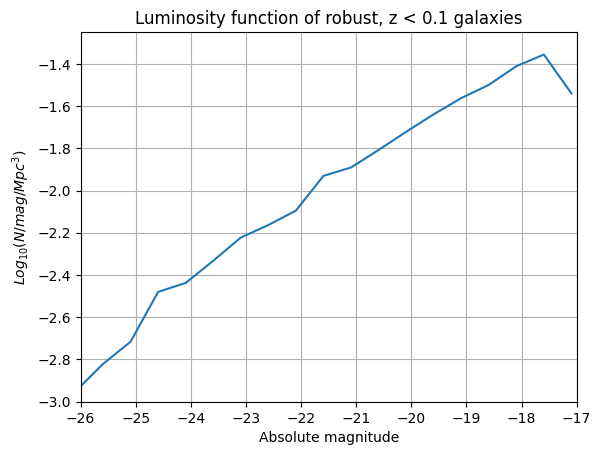

In [13]:
plot_lum_func()

Q9 Fit a Schechter function

The Schecter function is given by:

$$
n(M)dM = 0.4ln10\phi^*[10^{0.4(M^*- M)}]^{\alpha+1} \exp[-10^{0.4(M^*- M)}]dM
$$

In [14]:
def schecter_function(M, phi_star, M_star, alpha):
    """
    A function that calculates the schecter function 

    Parameters:
    - M, float, absolute magnitude
    - phi_star, float
    - M_star, INT/float
    -alpha, float

    returns:
    - n(M) from above
    """
    term1 = 0.4*np.log(10)*phi_star
    term2 = (10**(0.4* (M_star-M)))**alpha+1    
    term3 = np.exp(-10**(0.4*(M_star-M)))
    return term1 * term2 * term3

Optimal phi* value: 0.008 +- 0.002
Optimal M* value: -22.816 +- 0.542
Optimal alpha value: -0.277 +- 0.050


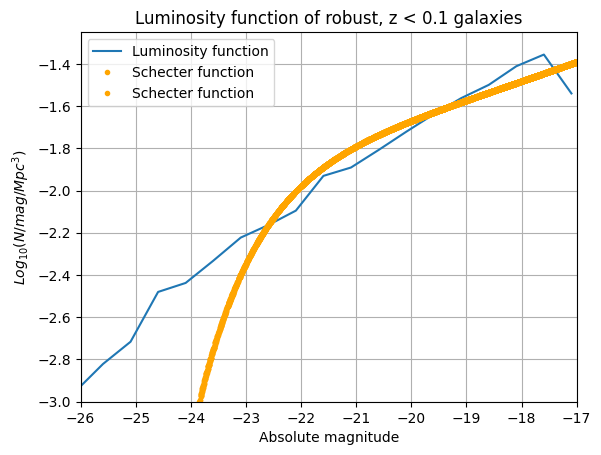

In [15]:
initial_guess = [0.5, -17.5, -1.5] 
#initial_guess = [0.5, -17.5, -0.1] 


popt, pcov = model = curve_fit(schecter_function, bincenters, phi, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

optimal_phi_star, optimal_M_star, optimal_alpha = popt
phi_star_err, M_star_err, alpha_err = perr


print(f"Optimal phi* value: {optimal_phi_star:.3f} +- {phi_star_err:.3f}")
print(f"Optimal M* value: {optimal_M_star:.3f} +- {M_star_err:.3f}")
print(f"Optimal alpha value: {optimal_alpha:.3f} +- {alpha_err:.3f}")

model = schecter_function(abs_mag, optimal_phi_star, optimal_M_star, optimal_alpha)
log_model = np.log10(model)

plot_lum_func()
plt.plot(abs_mag, log_model, '.', color="orange", label="Schecter function")
plt.legend()